# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.


## Ideas for Lane Detection Pipeline
Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project. The idea of Lane Detection on video is the same as the algorithm that we apply on image, because a video is a list of consecutive images. Therefore we need to build an algorithm that can works good on image. 

<ul>
    <li>1. Detect lane on test image
        <ul>
            <li>Get parameters of image</li>
            <li>Define color selection criteria</li>
            <li>Detect edges of image</li>
            <li>Draw lane from detected line segments</li>
        </ul>
    </li><br>
    <li>2. Apply Lane Detection on test video
        <ul>
            <li>Get height, width and FPS of video</li>
            <li>Tricky point</li>
        </ul>
    </li><br>
    <li>3. Summary
    </li>
</ul>


At the first step of this project, we have to include all nessecery libraries as below:


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import os

## 1. Detect lane on test image
We begin to build our algorithm by getting some stats of our test image, which has already been prepaired in the 'test_images' folder.

### Get parameters of image
Print out width, height, depth of test image

In [2]:
# Define name of test image
image_name = 'test_images/solidYellowCurve.jpg'

image = mpimg.imread(image_name)

In [3]:
# Get stats of image
def getImageStat(image):
    return np.shape(image)

In [4]:
img_height, img_width, img_depth = getImageStat(image)

In [5]:
print('This image is: ',type(image), 
    'with dimensions:', image.shape)
print('height:', img_height)
print('width:', img_width)
print('depth:', img_depth)

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
height: 540
width: 960
depth: 3


The test image will be displayed as below:

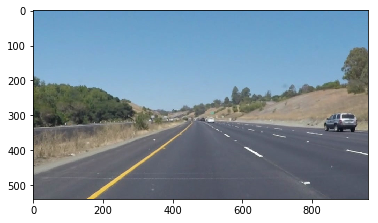

In [6]:
plt.imshow(image)
plt.show()

I make another copy of the image and working on this copy image.

In [7]:
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)

### Define color selection criteria
In this part, we define a color threshold and select any pixels below this threshold and set them to zero. Then we could get an image with the lane lines retain. Because we have both white and yellow lane lines, then we must modify the value very carefully to get both of this colors.

In [8]:
# Define our color selection criteria
# Great number for both yellow and white lane
red_threshold = 215
green_threshold = 0
blue_threshold = 0 

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [9]:
def convertToLaneRetain(rgb_threshold, image, color_select):
    # Identify pixels below the threshold
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    return color_select

In [10]:
color_select = convertToLaneRetain(rgb_threshold, image, color_select)

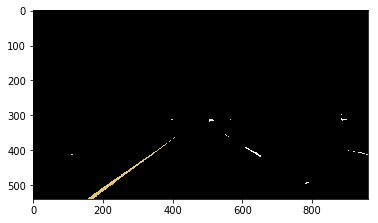

In [11]:
# Display the image                 
plt.imshow(color_select)
plt.show()

### Detect edges of image


In this step, we apply Canny Edge Detection algorithm to identify the boundaries of an object in an image. To do this, the image must be converted to grayscale, and then tracing out the pixels that follow the strongest gradients. By using OpenCV library, all we need to do is call the Canny function, with input is the gray image.

In [12]:
def CannyEdge(color_select, kernel_size, low_threshold, high_threshold, ignore_mask_color):
    gray = cv2.cvtColor(color_select,cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian smoothing
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Apply .Canny() function
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    
    return edges, mask

Define all parameters for our CannyEdge function:

In [13]:
# Kernel size 
kernel_size = 5

# Define our parameters for .Canny() function
low_threshold = 50
high_threshold = 150

# Define maske color
ignore_mask_color = 255 

In [14]:
edges, mask = CannyEdge(color_select, kernel_size, low_threshold, high_threshold, ignore_mask_color)

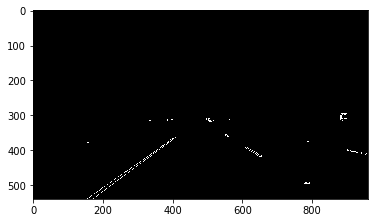

In [15]:
plt.imshow(edges, cmap='Greys_r')
plt.show()

Before we are going to detect line shape in this image, we need to restrict the area where we should find it, see the image below:

In [16]:
# Define the nodes of the red triangle area
red_left_bottom = [0, img_height]
red_right_bottom = [img_width, img_height]
red_apex = [img_width/2, img_height/2]

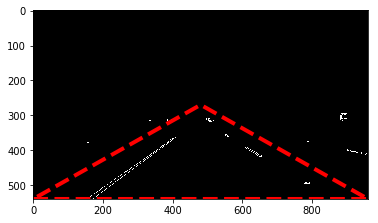

In [17]:
# Draw the red line
red_x = [red_left_bottom[0], red_right_bottom[0], red_apex[0], red_left_bottom[0]]
red_y = [red_left_bottom[1], red_right_bottom[1], red_apex[1], red_left_bottom[1]]
plt.plot(red_x, red_y, 'r--', lw=4)

plt.imshow(edges, cmap='Greys_r')
plt.show()

Sometimes if the camera is too close, then we should get some wrong values from the bottom of the area. And there should be some wrong line detected at the top of the triangle too. Therefore we must try to pick up some points independs on size of the input image, to build up a four side polygon that we should working on it - like the blue lines one:

In [18]:
def restrictedArea(img_height, img_width):
    # Define the nodes of the area
    left_bottom = [img_width/20, 0.95*img_height] # 5% of image's height margin bottom
    right_bottom = [0.95*img_width, 0.95*img_height]
    apex1 = [0.4*img_width, 0.6*img_height] # 40% of image's height margin bottom
    apex2 = [0.6*img_width, 0.6*img_height]
    
    return left_bottom, right_bottom, apex1, apex2

In [19]:
left_bottom, right_bottom, apex1, apex2 = restrictedArea(img_height, img_width)

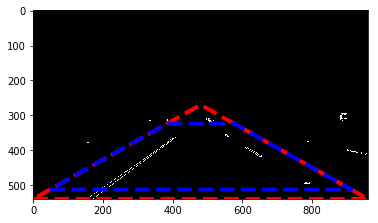

In [20]:
plt.plot(red_x, red_y, 'r--', lw=4)

# Display the image and show region and color selections
x = [left_bottom[0], right_bottom[0], apex2[0], apex1[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex2[1], apex1[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.imshow(edges, cmap='Greys_r')
plt.show()

Now we could implement a Hough Transform on Edge detected image, by using another OpenCV function called HoughLinesP. In this case we are operate on the image $edges$, and the output will be a list named: $lines$ which will simply be an array containing the end points $(x_1, y_1, x_2, y_2)$ of all line segments detected by the transform operation, inside the area $vertices$.

In [21]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 25     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

In [22]:
def HoughLinesDetection(x, y, mask, edges, image):
    vertices = np.array([[(x[0], y[0]),(x[1], y[1]), (x[2], y[2]), (x[3], y[3])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    return lines, color_edges

In [23]:
lines, color_edges = HoughLinesDetection(x, y, mask, edges, image)

In [24]:
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

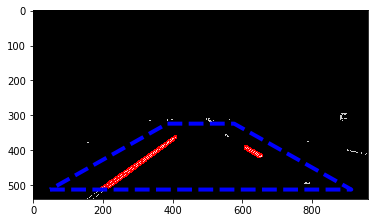

In [25]:
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.plot(x, y, 'b--', lw=4)
plt.imshow(lines_edges)
plt.show()

### Draw lane from detected line segments
We already have a list of line edges. In the next step we wil draw lane based on that line's edges. This step is a bit tricky to reach. First, our blue lines zone will be partitioned into two parts: right and left. And the Lane Detection algorithm will be applied for each part.

The code block below is showing how we could separate image.

In [26]:
# Display the image and show region and color selections
# Define the nodes of the left area
left_bottom_part_left = [img_width/20, 0.95*img_height] 
right_bottom_part_left = [0.5*img_width, 0.95*img_height]
apex1_part_left = [0.4*img_width, 0.6*img_height] 
apex2_part_left = [0.5*img_width, 0.6*img_height]

x_part_left = [left_bottom_part_left[0], right_bottom_part_left[0], apex2_part_left[0], apex1_part_left[0], 
               left_bottom_part_left[0]]
y_part_left = [left_bottom_part_left[1], right_bottom_part_left[1], apex2_part_left[1], apex1_part_left[1], 
               left_bottom_part_left[1]]


# Define the nodes of the right area
left_bottom_part_right = [0.5*img_width, 0.95*img_height] 
right_bottom_part_right = [0.95*img_width, 0.95*img_height]
apex1_part_right = [0.5*img_width, 0.6*img_height] 
apex2_part_right = [0.6*img_width, 0.6*img_height]

x_part_right = [left_bottom_part_right[0], right_bottom_part_right[0], apex2_part_right[0], apex1_part_right[0], 
               left_bottom_part_right[0]]
y_part_right = [left_bottom_part_right[1], right_bottom_part_right[1], apex2_part_right[1], apex1_part_right[1], 
               left_bottom_part_right[1]]

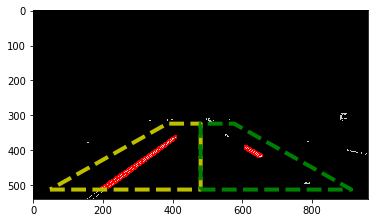

In [27]:
# Draw two parts of image
plt.plot(x_part_left, y_part_left, 'y--', lw=4)
plt.plot(x_part_right, y_part_right, 'g--', lw=4)

plt.imshow(lines_edges)
plt.show()

Let's take a took closer at list of all lines of this image: $lines$. Each element of $lines$ contains four values, which are coordinations of two points $P_1(x_1, y_1)$ and $P_2(x_2, y_2)$. The left part is the one which has x-Coordination smaller than half of image's width, and the right part has bigger x-Coordination than $1/2$ image's width.

In [28]:
print(lines[:5])

[[[192 513 408 362]]

 [[231 494 402 369]]

 [[609 391 655 416]]

 [[608 394 648 418]]

 [[216 505 279 460]]]


We must construct the line by two points: $P_1(x_1, y_1)$ and $P_2(x_2, y_2)$, then scale it to have lane of this image. The line always has a general form:
$$y = ax + b$$

This line go through point $P_1(x_1, y_1)$, that means: $y_1 = a.x_1 + b$ and through point 2: $y_2 = a.x_2 + b$

Therefore we could calculate two parameters $a$, $b$ of the line by $(x_1, y_1)$ and $(x_2, y_2)$:

$$a = \frac{(y_1 - y_2)}{(x_1 - x_2)}$$

$$b = y_1 - a.x_1$$

In [29]:
# The line form: y = ax+b
def getLineFunction(x1, y1, x2, y2):
    a = (y1-y2)/(x1-x2)
    b = y1-a*x1
    return a, b

In [30]:
# Calculate x when input is y
def getXCoordination(y, a, b):
    if (a == 0):
        a = 1e-06
    return (y - b)/a

In [31]:
# Calculate y when input is x
def getYCoordination(x, a, b):
    return a*x+b

An element of list $lines$ will be taken randomly to contruct the line. After have the line form, we must scale this line to the bottom of image and 40% height of image to have the lane shape.

In [32]:
def randomChoiceSide(side, lines):
    a = True
    
    while (a == True):
        if (side=='left'):
            rdn = random.choice(lines)
            # The left side always has x-Coordination smaller than half of image width
            if (rdn[0][0]<img_width/2):
                a = False
                
        if (side=='right'):
            rdn = random.choice(lines)
            # The right side always has x-Coordination bigger than half of image width
            if (rdn[0][0]>img_width/2):
                a = False
                
    return rdn

In [33]:
def getPointsCoord(side, lines):
    rdn = randomChoiceSide(side, lines)
    x1 = rdn[0][0]
    x2 = rdn[0][2]
    y1 = rdn[0][1]
    y2 = rdn[0][3]
    return x1, x2, y1, y2

Now we already have everything we need to calculate the line of lanes

In [34]:
# Check if any edges be detected on left or right side of the image
def checkExistEdges(side, lines, img_width):
    exist = False
    for line in lines:
        if (side == "left"):
            if (line[0][0] < img_width/2):
                exist = True
                break
        if (side == "right"):
            if (line[0][0] >= img_width/2):
                exist = True
                break
    return exist

In [35]:
def getLaneCoord(side, lines, img_height, img_width):
    result = []
    # If exist lines on side
    if (checkExistEdges(side, lines, img_width) == True):
        # Get random points from 'lines' list - left side
        x1, x2, y1, y2 = getPointsCoord(side, lines)

        # Get parameter of lane line
        a, b = getLineFunction(x1, y1, x2, y2)

        # Calculate x- and y-Coordination of lane line
        y_1 = img_height
        x_1 = getXCoordination(y_1, a, b)

        y_2 = 0.65*img_height
        x_2 = getXCoordination(y_2, a, b)
        
        result.append(x_1)
        result.append(x_2)
        result.append(y_1)
        result.append(y_2)
        
    return result

In [36]:
left_side = getLaneCoord('left', lines, img_height, img_width)
right_side = getLaneCoord('right', lines, img_height, img_width)

In [37]:
x_1_left, y_1_left, x_2_left, y_2_left = left_side
x_1_right, y_1_right, x_2_right, y_2_right = right_side

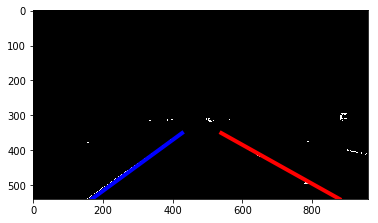

In [38]:
plt.plot([x_1_left, y_1_left], [x_2_left, y_2_left], 'b-', lw=4)
plt.plot([x_1_right, y_1_right], [x_2_right, y_2_right], 'r-', lw=4)
plt.imshow(edges, cmap='Greys_r')
plt.show()

Let's see how it looks like on test image:

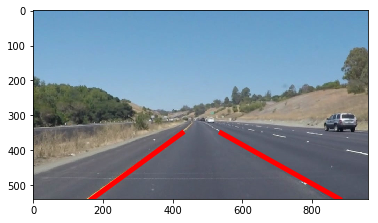

In [39]:
plt.plot([x_1_left, y_1_left], [x_2_left, y_2_left], 'r-', lw=5)
plt.plot([x_1_right, y_1_right], [x_2_right, y_2_right], 'r-', lw=5)
plt.imshow(image)
plt.show()

Now we could make the lane lines transparent with $addWeighted$ function. To do that, we need to make a blank image (with all black color) and draw the detected lines on it.

In [40]:
def transparentLines(image, left_side, right_side, color, pix):
    # Create a blank image
    line_img = line_image = np.copy(image)*0
    
    # Draw lines on it
    if np.any(left_side):
        x_1_left, x_2_left, y_1_left, y_2_left = left_side
        cv2.line(line_img, (int(round(x_1_left)), int(round(y_1_left))),\
                 (int(round(x_2_left)), int(round(y_2_left))), color, pix)

    if np.any(right_side):    
        x_1_right, x_2_right, y_1_right, y_2_right = right_side
        cv2.line(line_img, (int(round(x_1_right)), int(round(y_1_right))),\
                 (int(round(x_2_right)), int(round(y_2_right))), color, pix)
    
    # Create an image with transparent lane lines
    transparent_lines = cv2.addWeighted(image, 0.8, line_img, 1, 0)
    
    return transparent_lines

In [41]:
transparent_lines = transparentLines(image, left_side, right_side, (255,0,0), 10)

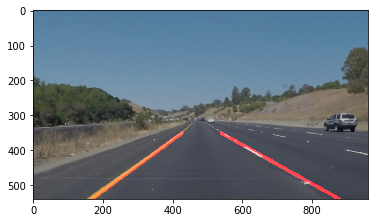

In [42]:
plt.imshow(transparent_lines)
plt.show()

As the result of this process above, our algorithm is stil not working smoothly in case it can not detects any edges after using Hough Transform. And the way we seperate image as two parts right and left could be improved by calculate slope of the linear. Or the way we choose an edge randomly to scale it to draw a linear could make a huge arithmetic. 

Another possible way to improve our algorithm is try to get edges from other RGB threshold values, which will be implemented in this section.

All steps should be written down inside a function, with an image as input, and output is the same input image with lane lines was be drawn on it.

The first improvement is adding more set of threshold values:

In [43]:
# Define set of color selection
set_rgb_threshold = {
    # number of set is in format [red, green, blue]
    "option1": [215, 0, 0], # Great number for both yellow and white lane
    "option2": [0, 0, 215]  # In case option1 is not work
}

And we should merge all edges which was detected by different threshold values:

In [44]:
def detectEdgeImage(image):
    # Get image stats
    img_height, img_width, img_depth = getImageStat(image)
    
    # Draw the red line
    red_x = [red_left_bottom[0], red_right_bottom[0], red_apex[0], red_left_bottom[0]]
    red_y = [red_left_bottom[1], red_right_bottom[1], red_apex[1], red_left_bottom[1]]

    # Define the nodes of the area
    left_bottom, right_bottom, apex1, apex2 = restrictedArea(img_height, img_width)

    # Display the image and show region and color selections
    x = [left_bottom[0], right_bottom[0], apex2[0], apex1[0], left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], apex2[1], apex1[1], left_bottom[1]]
    
    # Create a list to save all available edge for each set of threshold values
    total_lines = []
    
    # Detect edges of image with different set of threshold values
    for option, rgb_threshold_values in set_rgb_threshold.items():
        color_select = np.copy(image)
        color_select = convertToLaneRetain(rgb_threshold_values, image, color_select)
        
        edges, mask = CannyEdge(color_select, kernel_size, low_threshold, high_threshold, ignore_mask_color)
        
        lines = []
        # use Hough Transform on edges detection
        lines, color_edges = HoughLinesDetection(x, y, mask, edges, image)
        if np.any(lines):
            total_lines.extend(lines)
    return total_lines

In case we still could not detect the edges, the coordinate values will return an empty list. 

Write the algorithm as one function:

In [45]:
def laneDetectionImage(image):
    # Get image stats
    img_height, img_width, img_depth = getImageStat(image)

    total_lines = detectEdgeImage(image)
    
    left_side = getLaneCoord('left', total_lines, img_height, img_width)
    right_side = getLaneCoord('right', total_lines, img_height, img_width)
    
    transparent_lines = transparentLines(image, left_side, right_side, (0,0,255),20)

    return transparent_lines

To apply it to all images, we read all images in 'test_image' folder in a list and run it one by one:

In [46]:
# List all files in folder test_images
folder_path = "test_images"

In [47]:
# Read all file in folder and put in list
def readFiles(folder_path):
    list_of_files = []
    list_filename = []
    for filename in os.listdir(folder_path):
        list_of_files.append(folder_path + "/" + filename)
        list_filename.append(filename)
    return list_of_files, list_filename

In [48]:
list_of_images, list_filename = readFiles(folder_path)

To save the result in folder 'lane_detected_images', we should check if this folder is already exist, and if it's not, go create it.

In [49]:
# Check and create folder if it's not exist
def checkFolderExist(folder_path):
    if (os.path.exists(folder_path) == True):
        print("This folder "+ folder_path +" is already exist")
    else:
        os.makedirs(folder_path)

This folder lane_detected_images is already exist


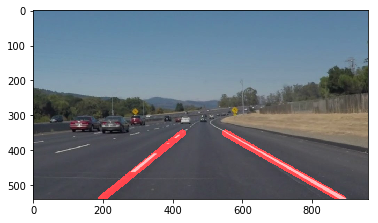

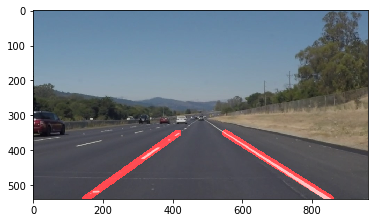

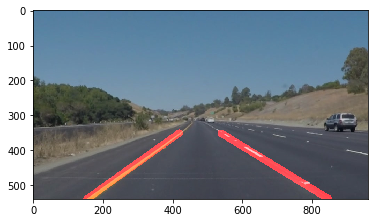

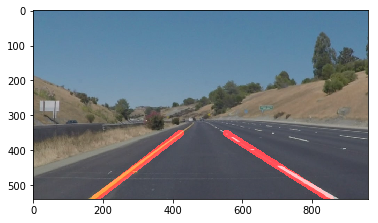

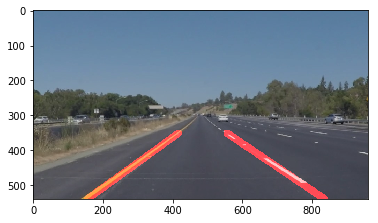

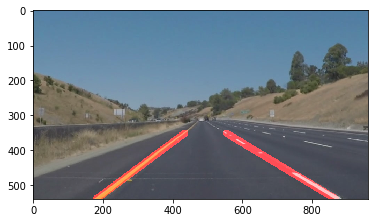

In [50]:
folder_path = "lane_detected_images"

# Check if the result folder exists, then save detected lane lines in it
checkFolderExist(folder_path)
    
# For each image in test_images folder
for ind, img_path in enumerate(list_of_images):
    image = cv2.imread(img_path, cv2.COLOR_BGR2RGB)

    # Detect lane and draw it
    lanelineImage = laneDetectionImage(image)
    
    # Save images
    path = folder_path+"/"+ list_filename[ind]
    cv2.imwrite(path, lanelineImage)
    
    plt.imshow(cv2.cvtColor(lanelineImage, cv2.COLOR_BGR2RGB))
    plt.show()

## 2. Apply Lane Detection on test video
For display and working with video, we must import some liberies:

In [51]:
import imageio

# Run this download command if necessary
#imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try to apply our algorithm on a sample test video in "test_video" folder. A video is a list of images, so we need to read every single frame of this video and apply our algorithm on each frame.

To do that, we need to get some parameters of our sample video:

### Get height, width and FPS of video

In [52]:
# Change the filename to run with another files

# filename = "challenge.mp4"
# filename = "solidWhiteRight.mp4"
filename = "solidYellowLeft.mp4"

In [53]:
vid_path = "test_videos/"+filename

In [54]:
# Capture this video
cap = cv2.VideoCapture(vid_path)

# Get height, width and FPS (frames per second) of video
vid_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
vid_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
vid_fps = cap.get(cv2.CAP_PROP_FPS)

In [55]:
# Choose another values of fourcc like H264, XVID etc. to save the video output as you want
# fourcc = cv2.VideoWriter_fourcc(*'X264')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')

In [56]:
# Define a parameter to write output video
out = cv2.VideoWriter('lane_detected_videos/'+filename, fourcc, vid_fps, (int(vid_width), int(vid_height)))

If we apply all the code above into a video now, it will not run smoothly because sometimes, the algorithm can only detect left lane or only right lane like this picture below:

<img src="vid_test.jpg" alt="Only Right Lane Detected" style="width: 720px;"/>

This picture was captured in video:<br>
'lane_detected_videos/solidWhiteRight_test.mp4'

Show this video in HTML:

In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("lane_detected_videos/solidWhiteRight_test.mp4"))

### Tricky point
Then, we should use some tricky here. In case our algorithm can not detect lane, we should use the lane detected in last frame. Let's see how it works:

In [58]:
# Set default values of lane lines coordiates
x_1_left, x_2_left, y_1_left, y_2_left = [1, 1, 1, 1]
x_1_right, x_2_right, y_1_right, y_2_right = [1, 1, 1, 1]

The code below will read a test video name: 'solidYellowLeft.mp4', detects lane lines and save the result in folder 'lane_detected_videos/solidYellowLeft.mp4'

In [59]:
while (cap.isOpened()):
    ret, frame = cap.read()
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if not ret:
        break
        
    # Get image stats
    img_height, img_width, img_depth = getImageStat(frame)
    total_lines = detectEdgeImage(frame)
    
    left_side = getLaneCoord('left', total_lines, img_height, img_width)
    right_side = getLaneCoord('right', total_lines, img_height, img_width)
    
    # Create a blank image
    line_img = line_image = np.copy(frame)*0
    
    # Draw lines on it
    if np.any(left_side):
        x_1_left, x_2_left, y_1_left, y_2_left = left_side
    cv2.line(line_img, (int(round(x_1_left)), int(round(y_1_left))),\
                 (int(round(x_2_left)), int(round(y_2_left))), (0,0,255), 20)
    
    if np.any(right_side):    
        x_1_right, x_2_right, y_1_right, y_2_right = right_side
    cv2.line(line_img, (int(round(x_1_right)), int(round(y_1_right))),\
                 (int(round(x_2_right)), int(round(y_2_right))), (0,0,255), 20)
    
    # Create an image with transparent lane lines
    transparent_lines = cv2.addWeighted(frame, 0.8, line_img, 1, 0)
    
    # To show video lives, remove the comment symbol of the next line
#     cv2.imshow("frame", transparent_lines)

    # Write output video
    out.write(transparent_lines)

cap.release()
out.release()
cv2.destroyAllWindows()

Show this result video in HTML:

In [63]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("lane_detected_videos/solidYellowLeft.mp4"))

Result of the 'solidWhiteRight.mp4' is shown below: 

In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("lane_detected_videos/solidWhiteRight.mp4"))

And let's see how it works with the challenge video:

In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("lane_detected_videos/challenge.mp4"))

## Summary
It was so much fun and knowledge when working with this project, especially when someone build it from scratch with your hints and guide like I do. 

There are so many thing we still can do to improve this algorithm. I have tried to calculate the average of the coordinates of edges, but it's not better than take a random edges, because sometimes a small strange edge, which is not really a part of lane line can make the average has a large deviation, too.

Although I need to use some tricky to make my algorithm works on challenge video, and I still have so many question about how can we solve the Lane Detection Problem on the road without lane lines. Maybe the answear is in the next project: Advanced Lane Detection.